$$
\Huge \text{TEORIA PERKOLACJI W POŻARACH LASÓW}
$$

$$
\Large \text{Autorzy: Alicja Górnik, Ewa Herman, Julia Krempińska, Jagoda Płócienniczak}
$$

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image, ImageDraw

#### 1. Drzewa mogą znajdować się w następujących stanach, opisanych poszczególnymi kolorami:
- 0 - brak drzewa (kolor biały)
- 1 - drzewo (kolor zielony)
- 2 - palące się drzewo (kolor czerwony)
- 3 - spalone drzewo (kolor szary)

In [109]:
tree_cond = {"EMPTY": 0, "TREE": 1, "BURNING": 2, "BURNED": 3}
tree_color = {0: "white", 1: "green", 2: "red", 3: "grey"}

#### 2. Poczatkowe parametry siatki 2D.

In [110]:
size = 50  # Rozmiar siatki
p_fire = 0.7   # Prawdopodobieństwo zapalenia sąsiedniego drzewa
p_tree = 0.6  # Prawdopodobieństwo początkowego istnienia drzewa / zalesienie

#### 3. Początkowa siatka 2D (jeszcze przed pożarem).

In [111]:
cmap = ListedColormap(tree_color.values())

In [112]:
def forest_grid(size, p_tree):
    forest = np.random.choice([tree_cond["EMPTY"], tree_cond["TREE"]], size=(size, size), p=[1-p_tree, p_tree])
    return forest

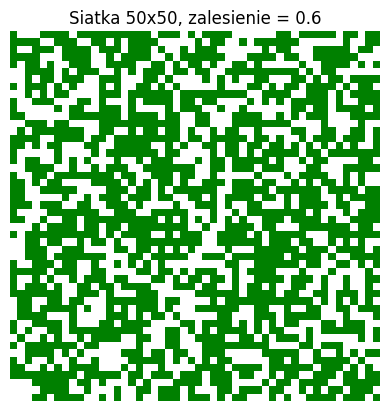

In [113]:
grid = forest_grid(size, p_tree)
plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
plt.axis('off')
plt.title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
plt.show()

#### 4. Sąsiedztwo (Von Neumanna i Moore'a)

In [114]:
def get_neighbors(x, y, size, neighborhood):
    if neighborhood == "von_neumann":
        neighbors = np.array([(x-1, y), (x+1, y), (x, y-1), (x, y+1)])
    elif neighborhood == "moore":
        neighbors = np.array([(x-1, y-1), (x-1, y), (x-1, y+1),  
                            (x, y-1), (x, y+1),             
                            (x+1, y-1), (x+1, y), (x+1, y+1)])
    else:
        return [] 
    neighbors = [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size] 
    return neighbors

#### 5. Pożar i jego rozprzestrzenianie się

In [115]:
def start_fire(forest_before_fire):
    forest = forest_before_fire.copy()
    forest[0, :] = np.where(forest[0, :] == tree_cond["TREE"], tree_cond["BURNING"], forest[0, :])
    return forest

In [116]:
def spread_fire(forest_with_fire, size, p_fire, neighborhood):
    new_forest = forest_with_fire.copy()
    size = forest_with_fire.shape[0]

    for x in range(size):
        for y in range(size):
            if forest_with_fire[x, y] == tree_cond["BURNING"]:
                new_forest[x, y] = tree_cond["BURNED"]
                
                for nx, ny in get_neighbors(x, y, size, neighborhood):
                    if forest_with_fire[nx, ny] == tree_cond["TREE"]:
                        if np.random.rand() < p_fire:
                            new_forest[nx, ny] = tree_cond["BURNING"]
    return new_forest

#### 6. Symulacja rozprzestrzeniania się ognia

In [117]:
def fire_simulation(size, p_fire, p_tree, neighborhood, gif_name, M_frames=100):
    forest = forest_grid(size, p_tree)
    frames = []

    for step in range(M_frames):
        if step == 0:
            fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
            ax.imshow(forest, cmap=cmap, vmin=0, vmax=3)
            ax.axis('off')
            ax.set_title(f'Pusty las {size}x{size}, zalesienie = {p_tree}')
            plt.draw()
            fig.canvas.draw()
            buf = fig.canvas.buffer_rgba()
            image = Image.frombytes('RGBA', fig.canvas.get_width_height(), buf)
            frames.append(image)
            plt.close(fig)

        elif step == 1:
            forest = start_fire(forest)
            fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
            ax.imshow(forest, cmap=cmap, vmin=0, vmax=3)
            ax.axis('off')
            ax.set_title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
            plt.draw()
            fig.canvas.draw()
            buf = fig.canvas.buffer_rgba()
            image = Image.frombytes('RGBA', fig.canvas.get_width_height(), buf)
            frames.append(image)
            plt.close(fig)

        else:
            forest = spread_fire(forest, size, p_fire, neighborhood)
            fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
            ax.imshow(forest, cmap=cmap, vmin=0, vmax=3)
            ax.axis('off')
            ax.set_title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
            plt.draw()
            fig.canvas.draw()

            buf = fig.canvas.buffer_rgba()
            image = Image.frombytes('RGBA', fig.canvas.get_width_height(), buf)
            frames.append(image)
            plt.close(fig)

    frames[0].save(f'{gif_name}.gif', save_all=True, append_images=frames[1:], loop=0, duration=200)
    print(f"Animacja została zapisana jako '{gif_name}.gif'")

In [118]:
fire_simulation(size = 100, p_fire = 1, p_tree = 0.6, neighborhood="von_neumann", gif_name = "Neumann_100x100", M_frames=200)

Animacja została zapisana jako 'Neumann_100x100.gif'


In [119]:
fire_simulation(size, p_fire, p_tree, neighborhood="moore", gif_name = "Moore_50x50", M_frames=100)

Animacja została zapisana jako 'Moore_50x50.gif'


#### 7. Szybkość rozprzestrzeniania się pożaru.

In [ ]:
def how_much_burned(size, p_fire, p_tree, neighborhood, M=100):
    burned = np.zeros(M)
    forest = forest_grid(size, p_tree)
    total_trees = np.sum(forest == tree_cond["TREE"])
    forest = start_fire(forest)
    
    for step in range(M):
        burned_trees = np.sum(forest == tree_cond["BURNED"]) + np.sum(forest == tree_cond["BURNING"])
        burned[step] = (burned_trees / total_trees) * 100 if total_trees > 0 else 0
        forest = spread_fire(forest, size, p_fire, neighborhood)

    return burned, np.arange(M)

##### 7.1. Rozprzestrzenianie się pożaru VS n-ty krok symulacji

- Przypadek jednej symulacji / jednego wyniku

In [121]:
M = 200
p_fire, p_tree = 1, 0.6
size = 50
burned_neumann_v1, steps = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
burned_moore_v1, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

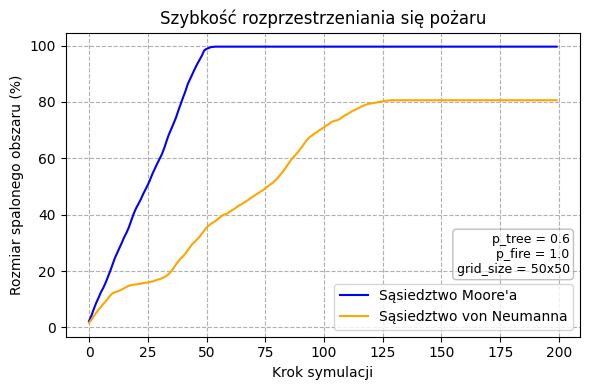

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(steps, burned_moore_v1, label="Sąsiedztwo Moore'a", color="blue")
plt.plot(steps, burned_neumann_v1, label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Krok symulacji')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {0.6}\np_fire = {1.0}\ngrid_size = {size}x{size}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("burned_vs_steps.png", dpi=300)
plt.show()

- Średnia z 100 symulacji

In [123]:
N = 100
M = 200
p_fire, p_tree = 1, 0.6
size = 50
burned_neumann_v2 = np.zeros((N, M))
burned_moore_v2 = np.zeros((N, M))
steps = np.arange(M)

for i in range(N):
    burned_neumann_v2[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
    burned_moore_v2[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

avg_burned_neumann = np.mean(burned_neumann_v2, axis=0)
avg_burned_moore = np.mean(burned_moore_v2, axis=0)

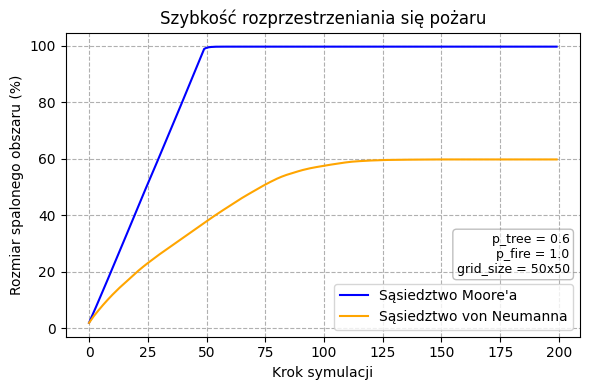

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(steps, avg_burned_moore, label="Sąsiedztwo Moore'a", color="blue")
plt.plot(steps, avg_burned_neumann, label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Krok symulacji')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {0.6}\np_fire = {1.0}\ngrid_size = {size}x{size}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("avg100_burned_vs_steps.png", dpi=300)
plt.show()

##### 7.2. Rozprzestrzenianie się pożaru VS wartość zalesienia (p_tree)

- Przypadek jednej symulacji / jednego wyniku

In [180]:
M = 200
p_fire = 1
p_tree_values = np.arange(0.1, 1.1, 0.1)
size = 50

In [181]:
burned_neumann_v3 = np.zeros((len(p_tree_values), M))
burned_moore_v3 = np.zeros((len(p_tree_values), M))
steps = np.arange(M)

for i, p_tree in enumerate(p_tree_values):
    burned_neumann_v3[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
    burned_moore_v3[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

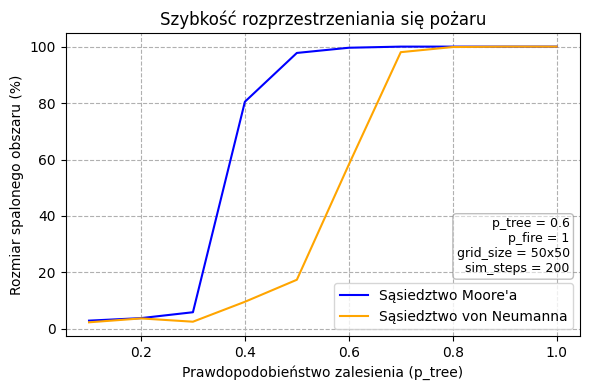

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(p_tree_values, burned_moore_v3[:,-1], label="Sąsiedztwo Moore'a", color="blue")
plt.plot(p_tree_values, burned_neumann_v3[:,-1], label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Prawdopodobieństwo zalesienia (p_tree)')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\ngrid_size = {size}x{size}\nsim_steps = {M}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("burned_vs_tree.png", dpi=300)
plt.show()

- Średnia z 100 symulacji

In [166]:
N = 100
M = 200
p_fire = 1
p_tree_values = np.arange(0.1, 1.1, 0.1)
size = 50

In [167]:
burned_neumann_v4 = np.zeros((len(p_tree_values), N))
burned_moore_v4 = np.zeros((len(p_tree_values), N))

for j in range(N):
    for i, p_tree in enumerate(p_tree_values):
        burned_neumann, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
        burned_moore, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

        burned_neumann_v4[i, j] = burned_neumann[-1]
        burned_moore_v4[i, j] = burned_moore[-1]

avg_burned_neumann_v2 = np.mean(burned_neumann_v4, axis=1)
avg_burned_moore_v2 = np.mean(burned_moore_v4, axis=1)

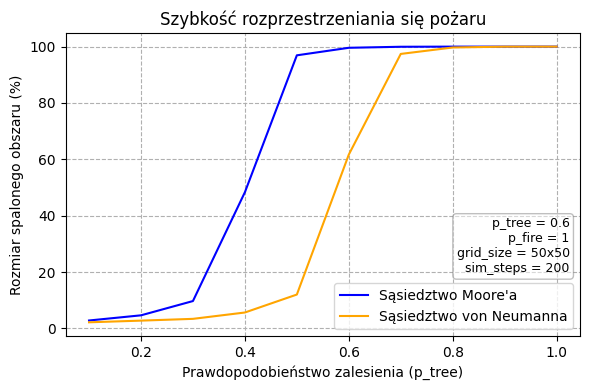

In [207]:
plt.figure(figsize=(6, 4))
plt.plot(p_tree_values, avg_burned_moore_v2, label="Sąsiedztwo Moore'a", color="blue")
plt.plot(p_tree_values, avg_burned_neumann_v2, label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Prawdopodobieństwo zalesienia (p_tree)')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\ngrid_size = {size}x{size}\nsim_steps = {M}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("avg100_burned_vs_tree.png", dpi=300)
plt.show()

##### 7.2. Rozprzestrzenianie się pożaru VS rozmiar siatki (size)

- Przypadek jednej symulacji / jednego wyniku

In [197]:
M = 200
p_fire, p_tree = 1, 0.6
size_values = np.arange(50, 300, 50)

In [198]:
burned_neumann_v5 = np.zeros((len(size_values), M))
burned_moore_v5 = np.zeros((len(size_values), M))

for i, size in enumerate(size_values):
    burned_neumann_v5[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
    burned_moore_v5[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

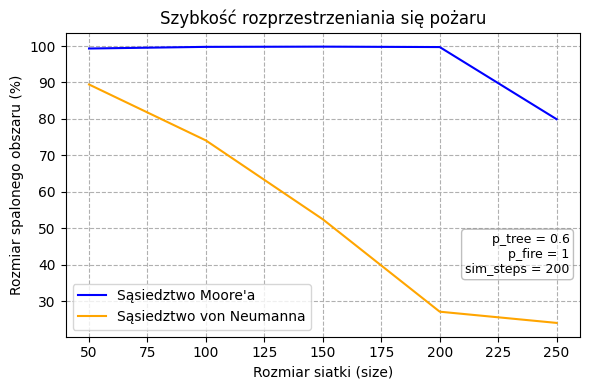

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(size_values, burned_moore_v5[:,-1], label="Sąsiedztwo Moore'a", color="blue")
plt.plot(size_values, burned_neumann_v5[:,-1], label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Rozmiar siatki (size)')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {0.6}\np_fire = {p_fire}\nsim_steps = {M}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower left")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("burned_vs_size.png", dpi=300)
plt.show()

- Średnia z 100 symulacji

In [208]:
M = 200
N = 100
p_fire, p_tree = 1, 0.6
size_values = np.arange(50, 300, 50)

In [ ]:
burned_neumann_v6 = np.zeros((len(size_values), N))
burned_moore_v6 = np.zeros((len(size_values), N))

for j in range(N):
    for i, size in enumerate(size_values):
        burned_neumann, _ = how_much_burned(size=size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
        burned_moore, _ = how_much_burned(size=size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

        burned_neumann_v6[i, j] = burned_neumann[-1]
        burned_moore_v6[i, j] = burned_moore[-1]

In [212]:
avg_burned_neumann_v3 = np.mean(burned_neumann_v6, axis=1)
avg_burned_moore_v3 = np.mean(burned_moore_v6, axis=1)

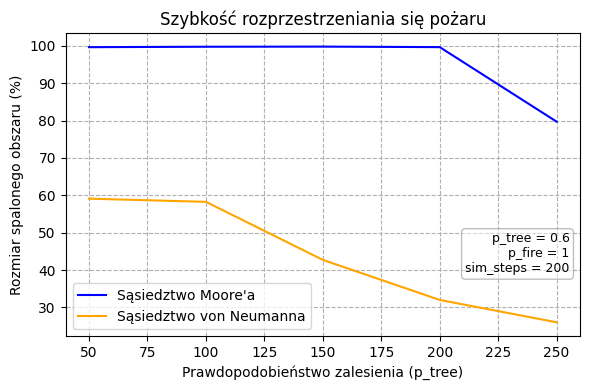

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(size_values, avg_burned_moore_v3, label="Sąsiedztwo Moore'a", color="blue")
plt.plot(size_values, avg_burned_neumann_v3, label="Sąsiedztwo von Neumanna", color="orange")
plt.xlabel('Prawdopodobieństwo zalesienia (p_tree)')
plt.ylabel('Rozmiar spalonego obszaru (%)')
plt.title('Szybkość rozprzestrzeniania się pożaru')
param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\nsim_steps = {M}"
plt.text(0.98, 0.2, param_text,
         transform=plt.gca().transAxes,  
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
plt.legend(loc = "lower left")
plt.grid(True, linestyle = '--')
plt.tight_layout()
#plt.savefig("avg100_burned_vs_size.png", dpi=300)
plt.show()